In [11]:
#Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("mental_health_dataset.csv")
df.head()

,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours
0,1,36,Non-binary,Sales,Canada,No,Medium,Yes,Medium,7.1,46,5
1,2,34,Female,Education,UK,Yes,NaN,No,Low,7.5,47,8
2,3,65,Non-binary,Sales,USA,Yes,High,No,Low,8.4,58,10
3,4,34,Male,Other,Australia,No,Low,No,Medium,9.8,30,2
4,5,22,Female,Healthcare,Canada,Yes,Low,No,Medium,4.9,62,5


In [15]:
#What data is in my set. Numeric data(age, sleep hour ex) and categoric (occupation) Also looking at mean for the different variables to see if i have intersting data to investigate.
#df.describe was used

In [17]:

!pip install scikit-learn

from sklearn.model_selection import RandomizedSearchCV


In [18]:
!pip install imblearn



In [22]:
#Prep code for model
#Dummy-coda categoric variables
df_encoded = pd.get_dummies(df, columns=['Gender', 'Occupation', 'Country', 'Stress_Level', 'Consultation_History'])

#Map Severity to numeric values
severity_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
df['Severity_Encoded'] = df['Severity'].map(severity_mapping)

#Distributionen in classes
print("Initial distribution of Severity_Encoded:")
print(df['Severity_Encoded'].value_counts())

#Outliers vere not found.
#Handle missing values and see classes are still left. missing values vere found in severity but is accepted and balanced.
df['Severity_Encoded'] = df['Severity_Encoded'].fillna(1).astype(int)

#Distributionen after imputation
print("Distribution of Severity_Encoded after imputering:")
print(df['Severity_Encoded'].value_counts())

#Separera features and target
X = df_encoded.drop(columns=['User_ID', 'Mental_Health_Condition', 'Severity', 'Severity_Encoded'])
y = df['Severity_Encoded']

#classes stil in place
print("Unika klasser i target:", y.unique())

# Balance datasetet, SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

#Distributionen after the SMOTE
print("Distribution after SMOTE:")
print(pd.Series(y_balanced).value_counts())

#All classes represented 
print("Unika klasser efter SMOTE:", pd.Series(y_balanced).unique())


Initial distribution of Severity_Encoded:
Severity_Encoded
0.0    176
2.0    159
Name: count, dtype: int64
Distribution of Severity_Encoded after imputering:
Severity_Encoded
1    665
0    176
2    159
Name: count, dtype: int64
Unika klasser i target: [1 2 0]
Distribution after SMOTE:
Severity_Encoded
1    665
2    665
0    665
Name: count, dtype: int64
Unika klasser efter SMOTE: [1 2 0]


Bästa parametrar: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Klassificeringsrapport för Severity:
              precision    recall  f1-score   support

         Low       0.89      0.79      0.84       138
      Medium       0.69      0.83      0.75       129
        High       0.88      0.80      0.84       132

    accuracy                           0.81       399
   macro avg       0.82      0.81      0.81       399
weighted avg       0.82      0.81      0.81       399

Konfusionsmatris:
[[109  25   4]
 [ 11 107  11]
 [  3  23 106]]
De viktigaste faktorerna för Severity:
Consultation_History_Yes    0.119595
Country_Germany             0.051861
Stress_Level_Medium         0.048839
Country_UK                  0.048246
Gender_Non-binary           0.045526
Consultation_History_No     0.042743
Country_USA                 0.041463
Gender_Male                 0.040388
Country_Canada              0.037961
Gender_Female               0.037113
dtype: float32


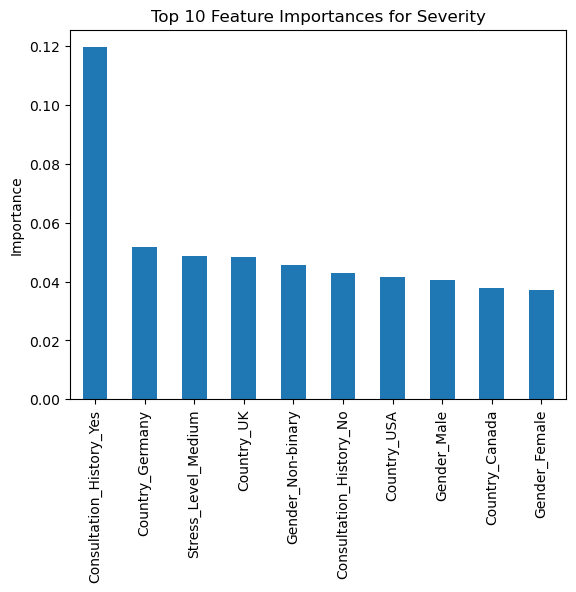

In [24]:
#Split datasetet to training and testpart
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

#Hyperparameteroptimization, GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
print("Bästa parametrar:", grid_search.best_params_)

#Use best model grid, GridSearch
xgb_model = grid_search.best_estimator_

#Train model in balanced dataset
xgb_model.fit(X_train, y_train)

#Predict and evaluation 
y_pred = xgb_model.predict(X_test)

#Show result
print("Klassificeringsrapport för Severity:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

print("Konfusionsmatris:")
print(confusion_matrix(y_test, y_pred))

#Importante features
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("De viktigaste faktorerna för Severity:")
print(feature_importances.head(10))

#Visualize important features for severity and save picture
feature_importances.head(10).plot(kind='bar', title='Top 10 Feature Importances for Severity')
plt.ylabel('Importance')
plt.show()


Bästa parametrar: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Klassificeringsrapport för Severity:
              precision    recall  f1-score   support

         Low       0.89      0.79      0.84       138
      Medium       0.69      0.83      0.75       129
        High       0.88      0.80      0.84       132

    accuracy                           0.81       399
   macro avg       0.82      0.81      0.81       399
weighted avg       0.82      0.81      0.81       399

Konfusionsmatris:
[[109  25   4]
 [ 11 107  11]
 [  3  23 106]]


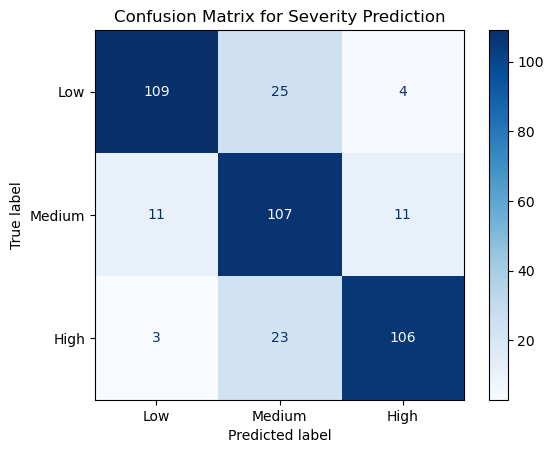

In [28]:
#Train and optimize model
grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    param_grid={
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    cv=3,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
print("Bästa parametrar:", grid_search.best_params_)

#Use of best model from GridSearch
xgb_model = grid_search.best_estimator_

#Train model on balanced data
xgb_model.fit(X_train, y_train)

#Predict and evaluation 
y_pred = xgb_model.predict(X_test)

#Show class for severity
print("Klassificeringsrapport för Severity:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

#show confusion matrix
print("Konfusionsmatris:")
print(confusion_matrix(y_test, y_pred))


from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Build and visualize Confusion Matrix
labels = ['Low', 'Medium', 'High']  # Etiketter för klasserna
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')  # Värden visas som heltal
plt.title('Confusion Matrix for Severity Prediction')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')  # Spara som bild
plt.show()


De viktigaste faktorerna för Severity:
Consultation_History_Yes    0.119595
Country_Germany             0.051861
Stress_Level_Medium         0.048839
Country_UK                  0.048246
Gender_Non-binary           0.045526
Consultation_History_No     0.042743
Country_USA                 0.041463
Gender_Male                 0.040388
Country_Canada              0.037961
Gender_Female               0.037113
dtype: float32


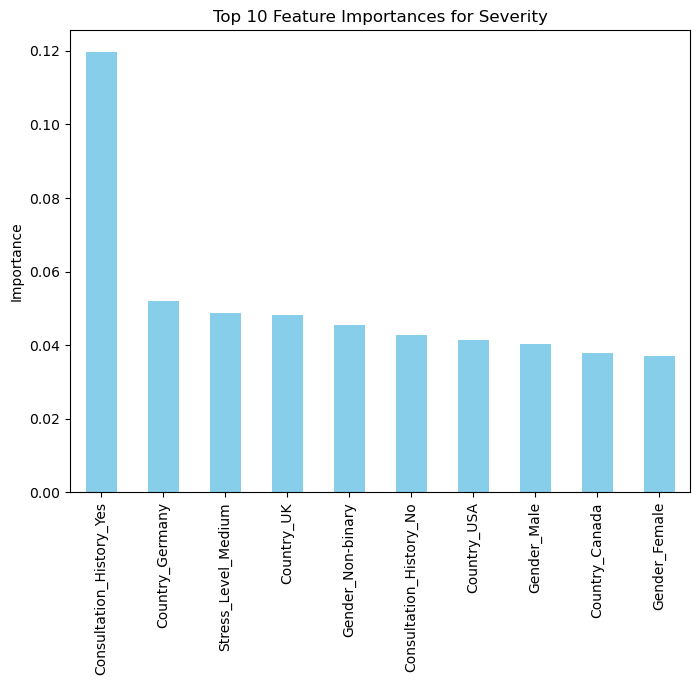

['.ipynb_checkpoints', 'app.py', 'Assignment_01.pdf', 'Average severity for occupation.png', 'ClassificationA18linka', 'confusion_matrix.png', 'DS24-AS1-A18linka.Regression.ipynb', 'DS24-AS2-A18linka.ipynb', 'DS24-Classification-A18linka.ipynb', 'DS24-Clustering-A18linka.ipynb', 'ENB2012_data.xlsx', 'featureImport_plot.png', 'feature_importance.png', 'feature_importance2.png', 'forestfires.csv', 'forestfires.names', 'loan_cleaned.csv', 'loan_train.csv', 'M24-Lab2-A18linka.ipynb', 'mall_customers_dataset.csv', 'mental_health_dataset.csv', 'Mini project data mining.ipynb', 'mlruns', 'model.h5', 'model.keras', 'my_plot.pdf', 'nltk_data', 'pic.png', 'preprocessor.pkl', 'S24-AS2-mlflow.ipynb', 'seaborn_histogram.pdf', 'seaborn_histogram.png', 'Testing.ipynb', 'training.1600000.csv', 'untitled.txt']


In [30]:
#Important factors, features with visualization for raport.
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("De viktigaste faktorerna för Severity:")
print(feature_importances.head(10))

# Visualiza important factors
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
feature_importances.head(10).plot(kind='bar', title='Top 10 Feature Importances for Severity', color='skyblue')
plt.ylabel('Importance')

#Save diagram, plt.show()
plt.savefig('feature_importance2.png', dpi=300, bbox_inches='tight')

#Show diagram
plt.show()

#Control save file 
import os
print(os.listdir())  # List,file


In [32]:
#Filter numeric columns
numeric_df = df.select_dtypes(include=[np.number])

#Control, which columns are numeric 
print("Numeriska kolumner:", numeric_df.columns)

#Calculate correlationmatrix
corr_matrix = numeric_df.corr()

#Sort correlations with need for severity_encoded
print("Korrelationer med Severity_Encoded:")
print(corr_matrix['Severity_Encoded'].sort_values(ascending=False))


Numeriska kolumner: Index(['User_ID', 'Age', 'Sleep_Hours', 'Work_Hours',
       'Physical_Activity_Hours', 'Severity_Encoded'],
      dtype='object')
Korrelationer med Severity_Encoded:
Severity_Encoded           1.000000
User_ID                    0.035755
Sleep_Hours                0.020408
Age                        0.016726
Physical_Activity_Hours    0.008573
Work_Hours                -0.009458
Name: Severity_Encoded, dtype: float64


<Axes: xlabel='Severity_Encoded', ylabel='Stress_Level'>

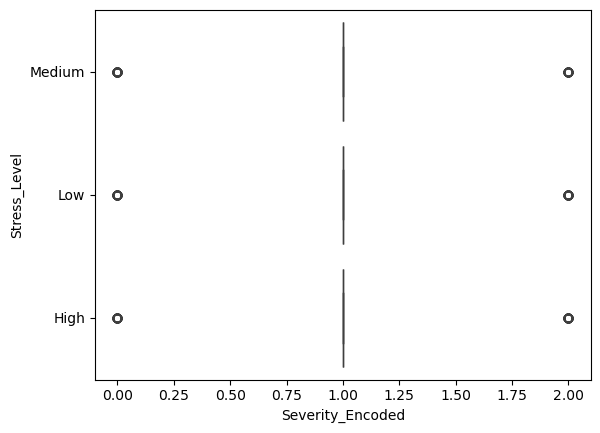

In [34]:
import seaborn as sns
sns.boxplot(x=df['Severity_Encoded'], y=df['Stress_Level'])


In [36]:
# Filter occupation and there correlation with Severity
occupation_columns = [col for col in df_encoded.columns if 'Occupation_' in col]
occupation_corr = df_encoded[occupation_columns + ['Severity_Encoded']].corr()['Severity_Encoded'].sort_values(ascending=False)
print("Korrelation mellan yrkeskategorier och Severity:")
print(occupation_corr)


Korrelation mellan yrkeskategorier och Severity:
Severity_Encoded          1.000000
Occupation_Finance        0.021799
Occupation_Education      0.021725
Occupation_Healthcare    -0.002267
Occupation_IT            -0.003762
Occupation_Other         -0.010643
Occupation_Engineering   -0.012091
Occupation_Sales         -0.013682
Name: Severity_Encoded, dtype: float64


In [38]:
#Group in occupation and count average Severity
severity_by_occupation = df.groupby('Occupation')['Severity_Encoded'].mean().sort_values(ascending=False)
print("Genomsnittlig Severity per yrkeskategori:")
print(severity_by_occupation)

# Group after occupation and count average Severity
severity_by_occupation = df.groupby('Occupation')['Severity_Encoded'].mean().sort_values(ascending=False)

#Show result, visualize
print("Genomsnittlig Severity per yrkeskategori:")
print(severity_by_occupation)



Genomsnittlig Severity per yrkeskategori:
Occupation
Education      1.014815
Finance        1.014388
Healthcare     0.979866
IT             0.977444
Other          0.968944
Engineering    0.966216
Sales          0.962963
Name: Severity_Encoded, dtype: float64
Genomsnittlig Severity per yrkeskategori:
Occupation
Education      1.014815
Finance        1.014388
Healthcare     0.979866
IT             0.977444
Other          0.968944
Engineering    0.966216
Sales          0.962963
Name: Severity_Encoded, dtype: float64


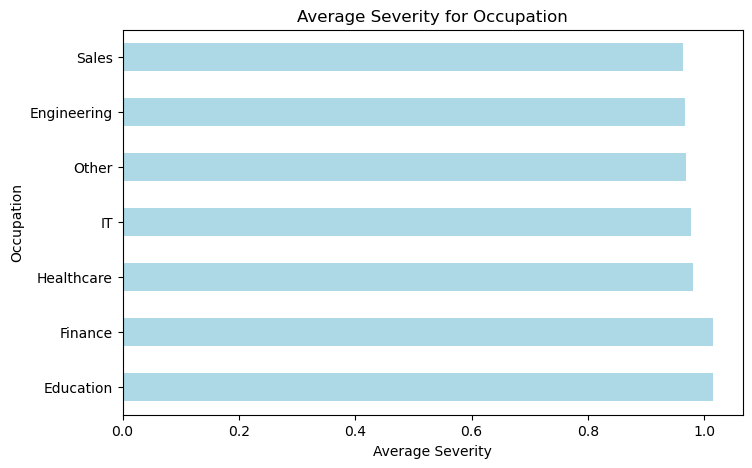

In [40]:
#Diagram
plt.figure(figsize=(8, 5))
severity_by_occupation.plot(kind='barh', color='lightblue')
plt.title('Average Severity for Occupation')
plt.xlabel('Average Severity')
plt.ylabel('Occupation')

# Spave diagram, plt.show()
plt.savefig('Average severity for occupation.png', dpi=300, bbox_inches='tight')

#Show diagram
plt.show()


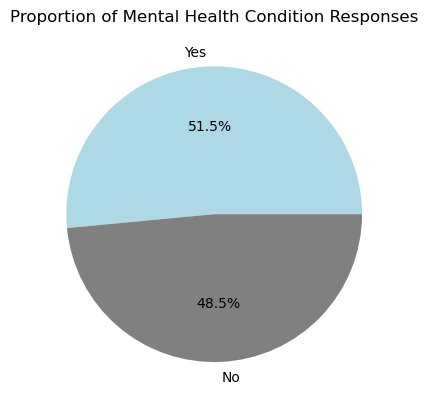

In [42]:
#Participants that answered YES/NO, mental health condition variable
condition_counts = df['Mental_Health_Condition'].value_counts()
condition_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Yes', 'No'], colors=['lightblue', 'gray'])
plt.title('Proportion of Mental Health Condition Responses')
plt.ylabel('')
plt.show()
